In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ['HF_HOME'] = 'hf_cache' # Don't want model files in our home directory due to disk quota
os.environ['OPENBLAS_NUM_THREADS'] = '1' # https://stackoverflow.com/questions/75619847/python-sklearn-openblas-error-for-kmeans

from utils import set_seed
import torch

set_seed(1234)

torch.cuda.is_available()

In [ ]:
from transformers import LukeTokenizer
import const
from model import DocRedModel
import json
from utils import get_holdouts, remove_holdouts, read_docred, collate_fn
from train import train_official, train_contrastive, train_dual
from torch.utils.data import DataLoader

checkpoint_path = 'out/holdout-batch-0/luke-base_contr_tmp-0.01_supw-0.5_embed-768_norm-True/checkpoints/latest-checkpoint.pt'
checkpoint_params = checkpoint_path.split('/')[2].split('_')

MODEL_NAME = const.LUKE_BASE
CONTR_TMP = 0.01
CONTR_SUP_W = 0.5
CONTR_EMBED_SIZE = 768
NORMALIZE = True
TRAIN_BATCH_SIZE = 4 # Should we reduce contrastive batch size to 3? This is what we ran originally 
DEV_BATCH_SIZE = 8

print(MODEL_NAME, CONTR_TMP, CONTR_SUP_W, NORMALIZE)

In [ ]:
rel2id_original = json.load(open('data/meta/rel2id.json'))
id2rel_original = {v: k for k, v in rel2id_original.items()}
tokenizer = LukeTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)

holdout_rel_batches = get_holdouts(train_samples_fp=const.TRAIN_SAMPLES_FP, # Get rel batches
                                    dev_samples_fp=const.DEV_SAMPLES_FP,
                                    rel2id=rel2id_original,
                                    id2rel=id2rel_original,
                                    tokenizer=tokenizer)
holdout_rels = holdout_rel_batches[0]

train_samples = read_docred(fp=const.TRAIN_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)
dev_samples = read_docred(fp=const.DEV_SAMPLES_FP, rel2id=rel2id_original, tokenizer=tokenizer)  

train_samples, rel2id_holdout, id2rel_holdout = remove_holdouts(samples=train_samples,
                                                                holdout_rels=holdout_rels,
                                                                rel2id=rel2id_original,
                                                                id2rel=id2rel_original)

train_dataloader = DataLoader(train_samples, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
dev_dataloader = DataLoader(dev_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)
val_train_dataloader = DataLoader(train_samples, batch_size=DEV_BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last=False)


In [ ]:
model = DocRedModel(model_name=MODEL_NAME,
                    tokenizer=tokenizer,
                    num_class=len(rel2id_holdout),
                    mode=const.MODE_CONTRASTIVE,
                    contr_temp=CONTR_TMP,
                    contr_sup_weight=CONTR_SUP_W,
                    out_embed_size=CONTR_EMBED_SIZE).to(const.DEVICE)
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

In [ ]:
from train import validate_epoch
import torch.nn.functional as F

embeddings, _, labels, labels_original, _ = validate_epoch(model, val_train_dataloader)
if NORMALIZE:
    print('NORMALIZING...')
    embeddings = F.normalize(embeddings, dim=-1)
embeddings.shape

In [16]:
from eval import get_masks, get_subset_masks, plot

pos_mask, holdout_mask, neg_mask = get_masks(labels, labels_original)
pos_mask.sum(), holdout_mask.sum(), neg_mask.sum()

(tensor(32627), tensor(2988), tensor(1163035))

In [15]:
# get magnitude of embeddings
magnitudes = torch.norm(embeddings, dim=-1)
magnitudes.min(), magnitudes.max()

(tensor(1.0000), tensor(1.0000))

In [1]:
from eval_contrastive import contrastive_evaluate
from pprint import pprint

stats, cand_mask = contrastive_evaluate(embeddings, labels, labels_original, id2rel_original)
pprint(stats)

NameError: name 'embeddings' is not defined

In [119]:
torch.save(cand_mask, 'out/holdout-batch-0/luke-base_contr_tmp-0.01_supw-0.5_embed-768_norm-True/checkpoints/best-contr-cand-mask.pt')

: 

In [114]:
reduce_fn = 'umap'

Dimension Reducing...


PLOT NUM POS: 32627
PLOT NUM HOLDOUT: 2988
PLOT NUM NEG: 84385
PLOT LABEL: ['P69'] (285) candidates, 22 non-candidates
PLOT LABEL: ['P54'] (281) candidates, 92 non-candidates
PLOT LABEL: ['P571'] (268) candidates, 192 non-candidates
PLOT LABEL: ['P570'] (619) candidates, 185 non-candidates
PLOT LABEL: ['P569'] (882) candidates, 162 non-candidates


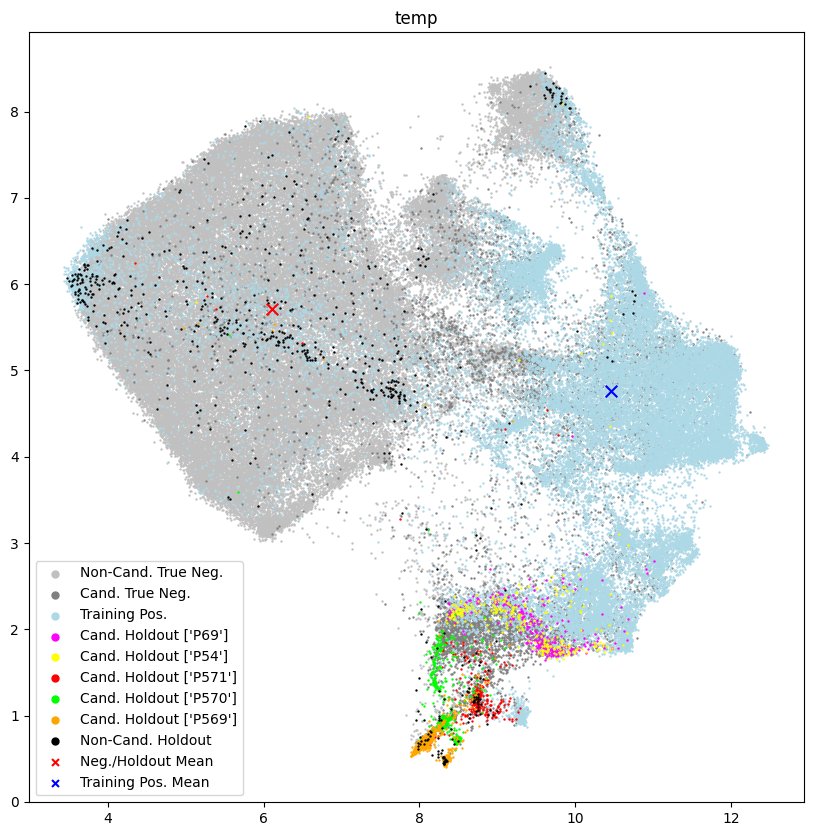

In [115]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='all_pos') # Plot all positives and holdouts w/ negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

In [ ]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='scale') # Plot scaled everything
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

Dimension Reducing...
PLOT NUM POS: 0
PLOT NUM HOLDOUT: 0
PLOT NUM NEG: 120000


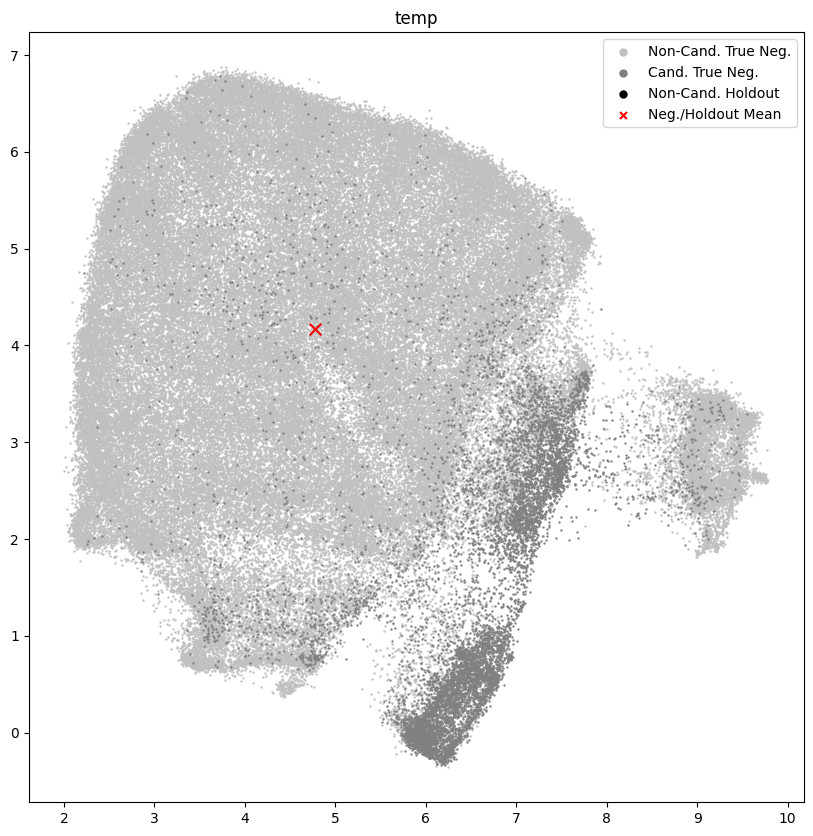

In [110]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, torch.zeros_like(holdout_mask), neg_mask, num=120_000, mode='only_holdout') # Plot only negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

Dimension Reducing...
PLOT NUM POS: 0
PLOT NUM HOLDOUT: 2988
PLOT NUM NEG: 117012
PLOT LABEL: ['P69'] (286) candidates, 21 non-candidates
PLOT LABEL: ['P54'] (276) candidates, 97 non-candidates
PLOT LABEL: ['P571'] (243) candidates, 217 non-candidates
PLOT LABEL: ['P570'] (605) candidates, 199 non-candidates
PLOT LABEL: ['P569'] (823) candidates, 221 non-candidates


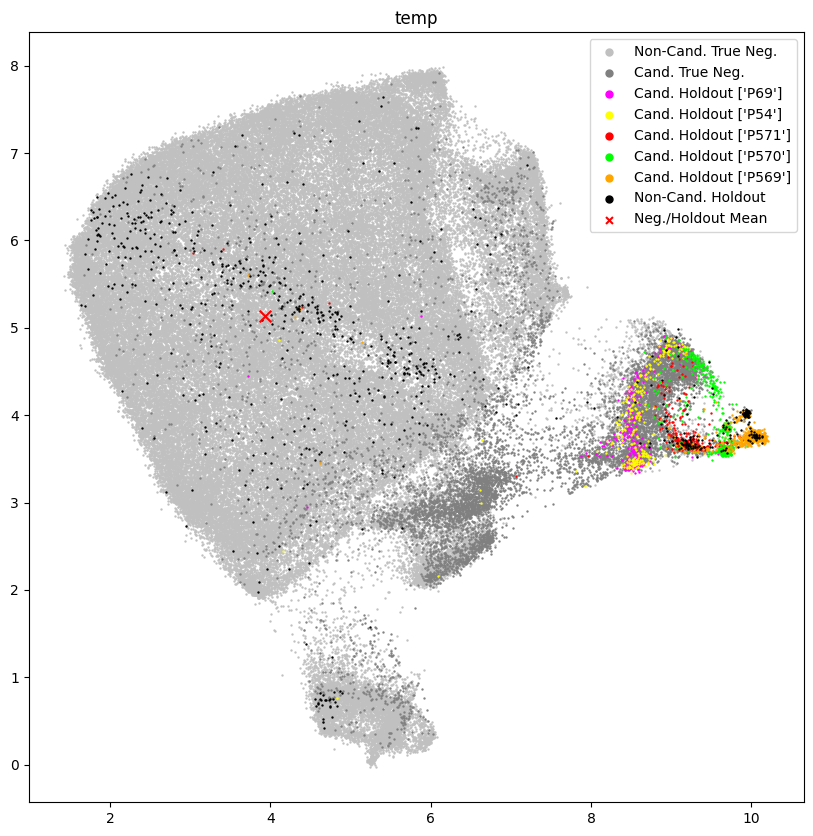

In [111]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, neg_mask, num=120_000, mode='only_holdout') # Plot only negatives and holdouts
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)

In [ ]:
p_pos_mask, p_holdout_mask, p_neg_mask = get_subset_masks(pos_mask, holdout_mask, torch.zeros_like(neg_mask), num=120_000, mode='all_pos') # Plot only positives and holdouts no negatives
plot(embeddings, labels_original, id2rel_original, p_pos_mask, p_holdout_mask, p_neg_mask, cand_mask, 'temp', 'temp.png', reduce_fn=reduce_fn)